In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from jaxtyping import Float, Int
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import einops as ein

%load_ext autoreload
%autoreload 2

## TODO
- Path patching for hypotheses that paths touching at least one of selected layers are not important
- Path patching for arbitrary sets of paths

## Path patching
![image](img/patching.png)

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")

In [23]:
@typed
def lincomb(
    alpha: float,
    x: TT | tuple,
    beta: float,
    y: TT | tuple,
) -> TT | tuple:
    if isinstance(x, tuple) and len(x) == 1:
        return lincomb(alpha, x[0], beta, y)
    if isinstance(y, tuple) and len(y) == 1:
        return lincomb(alpha, x, beta, y[0])
    if isinstance(x, TT) or isinstance(y, TT):
        assert x.shape == y.shape
        return alpha * x + beta * y
    else:
        assert len(x) == len(y)
        return tuple(lincomb(alpha, xi, beta, yi) for xi, yi in zip(x, y))


@typed
def activation_saver(
    inputs_dict: dict[str, TT | tuple],
    outputs_dict: dict[str, TT | tuple],
) -> Callable:
    @typed
    def hook(
        name: str, _module: nn.Module, input: TT | tuple, output: TT | tuple
    ) -> None:
        inputs_dict[name] = input
        outputs_dict[name] = output

    return hook


@typed
def sh(a: TT | tuple) -> list | tuple:
    if isinstance(a, tuple):
        return tuple(sh(x) for x in a)
    else:
        return list(a.shape)


@typed
def chain_patcher(
    steps: list[str],
    real_inputs: dict[str, TT | tuple],
    inputs_dict: dict[str, TT | tuple],
    outputs_dict: dict[str, TT | tuple],
) -> Callable:
    @typed
    def hook(
        name: str, _module: nn.Module, input: TT | tuple, output: TT | tuple
    ) -> TT | tuple:
        if name in steps:
            if "wte" in name:
                return output
            delta = lincomb(1.0, real_inputs[name], -1.0, input)
            if (
                len(output) > len(delta)
                and len(delta) == 1
                and isinstance(delta, tuple)
            ) or (isinstance(output, tuple) and isinstance(delta, TT)):
                a, b = output
                return (lincomb(1.0, a, 1.0, delta), b)
            output = lincomb(1.0, output, 1.0, delta)

        inputs_dict[name] = input
        outputs_dict[name] = output
        return output

    return hook


@typed
def ls(a) -> str:
    if isinstance(a, TT) and a.shape == ():
        return ls(a.item())
    if isinstance(a, float):
        return f"{a:.2f}"
    if isinstance(a, int) or isinstance(a, bool):
        return str(int(a))
    if not hasattr(a, "__len__"):
        return str(a)
    brackets = "()" if isinstance(a, tuple) else "[]"
    children = [ls(x) for x in a]
    if any("(" in x or "[" in x for x in children):
        delim = "\n"
    else:
        delim = " "
    return delim.join([brackets[0]] + children + [brackets[1]])


class Hooks:
    @typed
    def __init__(
        self,
        module: nn.Module,
        hook: Callable[[str, nn.Module, TT, TT], TT],
    ) -> None:
        from functools import partial

        self.handles = []
        self.module = module
        for name, submodule in module.named_modules():
            if "." in name:
                self.handles.append(
                    submodule.register_forward_hook(partial(hook, name))
                )

    @typed
    def __enter__(self) -> None:
        pass

    @typed
    def __exit__(self, *_) -> None:
        for handle in self.handles:
            handle.remove()

In [32]:
from utils import get_logprobs, tokenize, logprobs_to_losses


@typed
def cross_loss(prompt: str, label: str) -> float:
    logprobs: Float[TT, "seq vocab"] = get_logprobs(model, tokenizer, prompt)
    ids: Int[TT, "seq"] = tokenize(tokenizer, label)["input_ids"][0]
    assert len(logprobs) == len(ids)
    losses: Float[TT, "seq"] = logprobs_to_losses(logprobs, ids)
    return losses[1:].mean().item()


@typed
def get_activations(
    prompt: str,
) -> tuple[dict[str, TT | tuple], dict[str, TT | tuple], Float[TT, "seq vocab"]]:
    inputs_dict: dict[str, TT | tuple] = {}
    outputs_dict: dict[str, TT | tuple] = {}
    with Hooks(model, activation_saver(inputs_dict, outputs_dict)):
        logprobs = get_logprobs(model, tokenizer, prompt)
    return inputs_dict, outputs_dict, logprobs


layer_list = ["transformer.wte"] + [f"transformer.h.{i}" for i in range(8)] + ["transformer.lm_head"]


@typed
def path_patching(
    real_prompt: str, corrupted_prompt: str, patched_layers: list[int]
) -> float:
    real_inputs: dict[str, TT | tuple] = {}
    real_outputs: dict[str, TT | tuple] = {}
    with Hooks(model, activation_saver(real_inputs, real_outputs)):
        real_loss = cross_loss(prompt=real_prompt, label=real_prompt)

    corrupted_inputs: dict[str, TT | tuple] = {}
    corrupted_outputs: dict[str, TT | tuple] = {}
    steps = [layer_list[i] for i in patched_layers]
    with Hooks(
        model,
        chain_patcher(
            steps=steps,
            real_inputs=real_inputs,
            inputs_dict=corrupted_inputs,
            outputs_dict=corrupted_outputs,
        ),
    ):
        corrupted_loss = cross_loss(prompt=corrupted_prompt, label=real_prompt)
    return corrupted_loss - real_loss


@typed
def patch_all_pairs(
    real_prompt: str, corrupted_prompt: str
) -> Float[TT, "n_layers n_layers"]:
    n_layers = len(layer_list)
    losses: Float[TT, "n_layers n_layers"] = t.zeros((n_layers, n_layers))
    for i in range(n_layers):
        for j in range(n_layers):
            losses[i, j] = path_patching(
                real_prompt=real_prompt,
                corrupted_prompt=corrupted_prompt,
                patched_layers=[i, j],
            )
    return losses

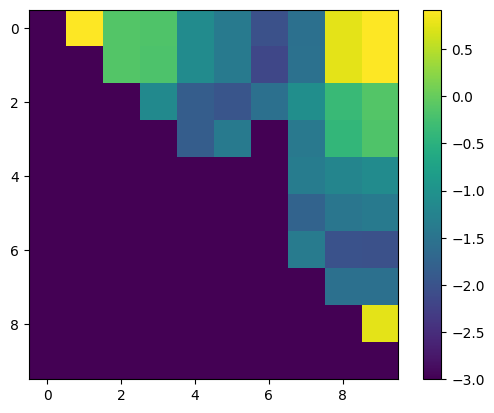

In [38]:
res = patch_all_pairs(
    "<10 <11 <12 <13 <14 14> 13> 12> 11> 10>", "<1 <2 <3 <4 <5 5> 4> 3> 2> 1>"
)
res = t.triu(res, diagonal=1)
plt.imshow(res.clip(1e-3, 100).log10())
plt.colorbar()
plt.show()

In [36]:
from itertools import combinations

edges = []
for i, j in combinations(range(10), 2):
    edges.append((res[j, i].item(), (i, j)))
edges.sort(reverse=True)
print(*edges, sep="\n")

(8.24734115600586, (0, 9))
(8.189884185791016, (1, 9))
(8.189884185791016, (0, 1))
(5.743729114532471, (8, 9))
(5.743729114532471, (0, 8))
(5.69450044631958, (1, 8))
(0.7383580207824707, (2, 9))
(0.7383580207824707, (0, 2))
(0.7370469570159912, (1, 2))
(0.692598819732666, (3, 9))
(0.692598819732666, (0, 3))
(0.6753051280975342, (1, 3))
(0.451524019241333, (2, 8))
(0.39169812202453613, (3, 8))
(0.08630561828613281, (2, 7))
(0.0782175064086914, (1, 4))
(0.07703280448913574, (4, 9))
(0.07703280448913574, (0, 4))
(0.07102060317993164, (2, 3))
(0.061568260192871094, (4, 8))
(0.0437164306640625, (4, 7))
(0.041863441467285156, (6, 7))
(0.040996551513671875, (1, 5))
(0.03939485549926758, (5, 9))
(0.03939485549926758, (0, 5))
(0.03913164138793945, (3, 5))
(0.03796219825744629, (3, 7))
(0.03500485420227051, (5, 8))
(0.028675317764282227, (1, 7))
(0.028353452682495117, (7, 9))
(0.028353452682495117, (0, 7))
(0.02823662757873535, (2, 6))
(0.027743101119995117, (7, 8))
(0.017481088638305664, (5, 7)